In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

data: np.ndarray = pd.read_csv("/kaggle/input/cities/Dubai.csv").values

In [2]:
# convert date to number of days since 01/01/2020
def days_since_zero_date(date_str: str) -> int:
    # Converting a string to a datetime object
    date_format: str = "%Y-%m-%d"
    
    date_obj = datetime.strptime(date_str, date_format)
    
    zero_date = datetime.strptime("2020-01-01", date_format)
    delta = date_obj - zero_date
    days = delta.days
    return days

data[:, 0] = np.vectorize(days_since_zero_date)(data[:, 0])

data = data.astype("float")
print(data)

[[0.000e+00 2.130e+01 6.300e+01 2.150e+01]
 [1.000e+00 2.170e+01 7.500e+01 1.700e+01]
 [2.000e+00 2.130e+01 7.000e+01 1.210e+01]
 ...
 [1.891e+03 2.420e+01 4.800e+01 1.700e+01]
 [1.892e+03 2.760e+01 2.800e+01 1.450e+01]
 [1.893e+03 2.880e+01 2.000e+01 1.390e+01]]


In [3]:
ratio = 0.9
index = int(data.shape[0] * ratio)
train_data = data[:index]
test_data = data[index:]
print(train_data)

[[0.000e+00 2.130e+01 6.300e+01 2.150e+01]
 [1.000e+00 2.170e+01 7.500e+01 1.700e+01]
 [2.000e+00 2.130e+01 7.000e+01 1.210e+01]
 ...
 [1.701e+03 3.440e+01 7.200e+01 2.870e+01]
 [1.702e+03 3.440e+01 6.400e+01 1.900e+01]
 [1.703e+03 3.390e+01 7.600e+01 2.020e+01]]


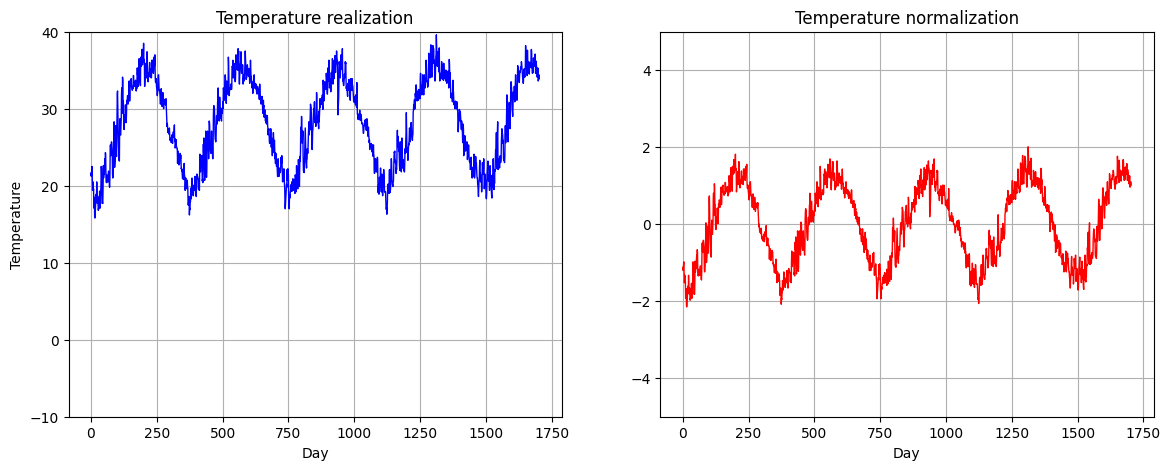

In [4]:
# Data Normalization Layer
class Normalize:
    def __init__(self, data: np.ndarray) -> None:
        self.data: np.ndarray = np.copy(data)
        self.__mean: np.ndarray = data.mean(axis=0)
        self.__std_dev: np.ndarray = data.std(axis=0)
        # Avoid dividing by zero
        self.__std_dev[self.__std_dev == 0] = 1.0

    def normalizeData(self) -> np.ndarray:
        return (self.data - self.__mean) / self.__std_dev

    def DeNormalizeData(self, normalized_data: np.ndarray, axes=None) -> np.ndarray:
        if axes is None:
            return normalized_data * self.__std_dev + self.__mean
        else:
            return normalized_data * self.__std_dev[axes] + self.__mean[axes]

train_normalize_class = Normalize(train_data[:, 1:])

normalized_data = train_normalize_class.normalizeData()  

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Set axis limits and labels
ax[1].set_ylim([-5, 5])  
ax[0].set_ylim([-10, 40])

ax[0].set_ylabel("Temperature")
ax[0].set_xlabel("Day")
ax[1].set_xlabel("Day")

ax[0].set_title("Temperature realization")
ax[1].set_title("Temperature normalization")

ax[0].grid()
ax[1].grid()

ax[0].plot(train_data[:, 1], c="b", linewidth=1)
ax[1].plot(normalized_data[:, 0], c="r", linewidth=1)

plt.show()

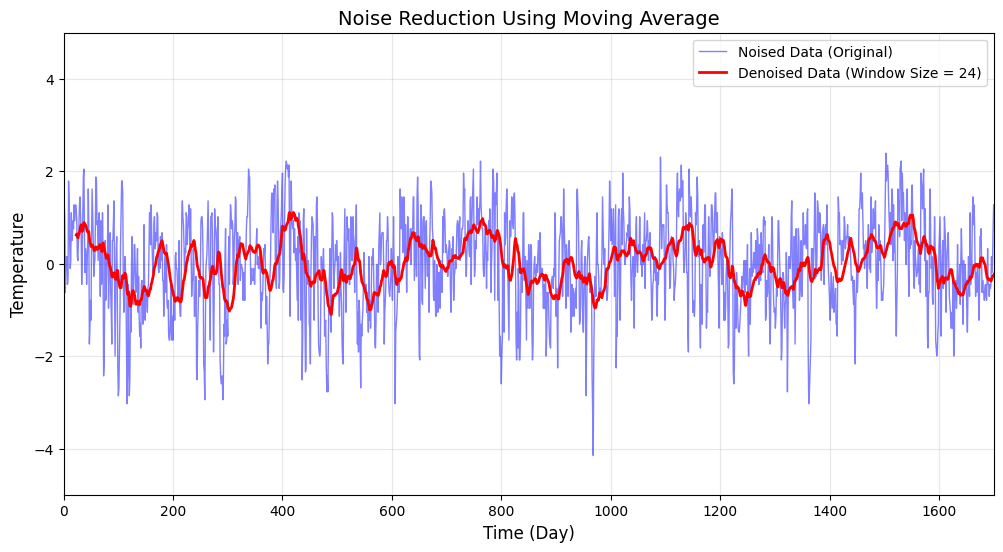

In [5]:
#  Data Smoothing
window_size = normalized_data.shape[0]//70  
denoised_train = (
    pd.Series(normalized_data[:, 1])  
    .rolling(window=window_size)
    .mean()
    .iloc[window_size - 1:]
    .values
)

# Graph
plt.figure(figsize=(12, 6))  

# normalized data (noised data)
plt.plot(normalized_data[:, 1], 
         c="blue", 
         alpha=0.5,  
         linewidth=1, 
         label="Noised Data (Original)")

# smooted data (denoised data)
plt.plot(np.arange(window_size - 1, len(normalized_data)), 
         denoised_train, 
         c="red", 
         linewidth=2, 
         label=f"Denoised Data (Window Size = {window_size})")

plt.title("Noise Reduction Using Moving Average", fontsize=14)
plt.xlabel("Time (Day)", fontsize=12)
plt.ylabel("Temperature", fontsize=12)
plt.ylim(-5, 5)  
plt.xlim(0, 1700)
plt.grid(alpha=0.3)
plt.legend()  

plt.show()

In [6]:
# smoothing data with moving average
def denoise_data(data: np.ndarray, window_size: int) -> np.ndarray:
    return pd.Series(data).rolling(window=window_size).mean().iloc[window_size - 1:].values
    
# Caculate MAE
def MAE(predictions: np.ndarray, labels: np.ndarray) -> float:
    return np.mean(np.abs(predictions - labels))

# Find the main frequency by Fourier transform
def find_dominant_frequencies(data: np.ndarray, num_frequencies: int) -> np.ndarray:
    mfft: np.ndarray = np.fft.fft(data)
    imax: np.ndarray = np.argsort(np.absolute(mfft))[::-1]
    imax = imax[:num_frequencies]
    frequencies: np.ndarray = np.array(imax) / len(data)
    return frequencies

# processing for each city and parameter
def train_model_with_params(x_data, y_data, init_params, bias, number_of_sinuses, 
                           learning_rate, beta_1, beta_2, epochs=50):
    
    # Model
    class SinLayer(layers.Layer):
        def __init__(self):
            super(SinLayer, self).__init__()

        def build(self, _):
            self.kernel = self.add_weight(name="kernel", shape=(number_of_sinuses, 3), trainable=True)
            self.bias = self.add_weight(name="bias", shape=(), trainable=True)

        def call(self, inputs):
            result = 0
            for i in range(number_of_sinuses):
                result += self.kernel[i][0] * tf.sin(
                    self.kernel[i][1] * inputs + self.kernel[i][2]
                )
            return result + self.bias
    
    # Model Building
    inputs = keras.Input(shape=(1,))
    outputs = SinLayer()(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Set initial weights
    model.set_weights([init_params, bias])
    
    history = model.fit(x_data, y_data, epochs=epochs, verbose=0)
    
    return model, history

In [7]:
# grid search to find optimal parameters for each city and parameter
def grid_search_optimizer(city_file, parameter, number_of_sinuses=4, cv_folds=3):
    # Read data
    city_name = os.path.basename(city_file).replace('.csv', '')
    print(f"Optimized for {city_name} - {parameter}...")
    
    df = pd.read_csv(city_file)
    
    # Check if parameter exists
    if parameter not in df.columns:
        print(f"  Parameter {parameter} is not present in the data")
        return None, None, None
    
    # Convert date
    df['days'] = df['date'].apply(days_since_zero_date)
    
    # Prepart data
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    # Normalize parameter data
    normalize_class = Normalize(data[:, 1].reshape(-1, 1))
    normalized_data = normalize_class.normalizeData().flatten()
    
    # Data Smoothing
    window_size = max(1, len(normalized_data) // 70)
    if len(normalized_data) <= window_size:
        print(f"  Not enough data for {parameter}")
        return None, None, None
    
    denoised_data = denoise_data(normalized_data, window_size)
    
    # Frequency calculation via Fourier transform
    x_data = np.linspace(0, len(denoised_data), len(denoised_data))
    frequencies = find_dominant_frequencies(denoised_data, number_of_sinuses)
    
    # Initialize parameters
    init_params = np.array([
        np.array([np.std(denoised_data), frequencies[i] * 2 * np.pi, 0.0])
        for i in range(number_of_sinuses)
    ])
    bias = np.mean(denoised_data)

    learning_rates = [0.001]
    beta_1_values = [0.7, 0.8, 0.9]
    beta_2_values = [0.9, 0.95, 0.99]
    
    # Tạo KFold cross-validator
    # kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    best_params = None
    best_mae = float('inf')
    
    # grid search
    for lr in learning_rates:
        for b1 in beta_1_values:
            for b2 in beta_2_values:
                # Ignore when beta_2 <= beta_1 (invalid for Adam)
                if b2 <= b1:
                    continue
                
                cv_maes = []
                
                # Cross-validation
                for train_idx, val_idx in tscv.split(x_data):
                    x_train, x_val = x_data[train_idx], x_data[val_idx]
                    y_train, y_val = denoised_data[train_idx], denoised_data[val_idx]
                
                    model, _ = train_model_with_params(
                        x_train, y_train, init_params, bias, number_of_sinuses,
                        lr, b1, b2, epochs=10
                    )
                    
                    # Prediction on validation set
                    val_preds = model.predict(x_val.reshape(-1, 1), verbose=0)
                    
                    # Calculate MAE on standardized data
                    val_mae = MAE(val_preds.flatten(), y_val)
                    cv_maes.append(val_mae)
                
                # Calculate average MAE over folds
                avg_mae = np.mean(cv_maes)
                
                # Check if this is the best parameter
                if avg_mae < best_mae:
                    best_mae = avg_mae
                    best_params = {'learning_rate': lr, 'beta_1': b1, 'beta_2': b2}
                    print(f"  Better parameters found: {best_params}, MAE: {best_mae:.6f}")
    
    if best_params:
        # Train the final model with the best parameters on the entire dataset
        final_model, history = train_model_with_params(
            x_data, denoised_data, init_params, bias, number_of_sinuses,
            best_params['learning_rate'], best_params['beta_1'], best_params['beta_2'],
            epochs=50
        )
        
        print(f"  Optimized parameters for {city_name} - {parameter}: {best_params}")
        return final_model, best_params, best_mae, history
    else:
        return None, None, None, None

In [8]:
# Get the list of file CSV
cities_files = glob.glob('/kaggle/input/cities/*.csv')

# List of parameters to be modeled
parameters = ['temperature_avg', 'humidity_avg', 'wind_speed_max']

results = {}

for city_file in cities_files:
    city_name = os.path.basename(city_file).replace('.csv', '')
    results[city_name] = {'models': {}, 'best_params': {}, 'metrics': {}, 'histories': {}} 
    
    for param in parameters:
        model, best_params, mae, history = grid_search_optimizer(city_file, param)
        if model is not None:
            results[city_name]['models'][param] = model
            results[city_name]['best_params'][param] = best_params
            results[city_name]['metrics'][param] = mae
            results[city_name]['histories'][param] = history

print("\nOptimization results:")
for city_name, city_results in results.items():
    print(f"\nCity: {city_name}")
    for param in city_results['best_params']:
        print(f"  - {param}: ")
        print(f"    + Optimal parameter: {city_results['best_params'][param]}")
        print(f"    + MAE: {city_results['metrics'][param]:.6f}")
        print(f"    + Loss: {city_results['histories'][param].history['loss'][-1]:.6f}")

Optimized for Ho Chi Minh City - temperature_avg...
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}, MAE: 0.734247
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.95}, MAE: 0.557276
  Optimized parameters for Ho Chi Minh City - temperature_avg: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.95}
Optimized for Ho Chi Minh City - humidity_avg...
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}, MAE: 1.058474
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.95}, MAE: 0.880706
  Optimized parameters for Ho Chi Minh City - humidity_avg: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.95}
Optimized for Ho Chi Minh City - wind_speed_max...
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}, MAE: 0.637315
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.99}, MAE: 0.617635
  Better parameters found: {

In [9]:
# analys
optimal_learning_rates = {}
optimal_beta_1s = {}
optimal_beta_2s = {}

for param in parameters:
    optimal_learning_rates[param] = []
    optimal_beta_1s[param] = []
    optimal_beta_2s[param] = []
    
    for city_name, city_results in results.items():
        if param in city_results['best_params'] and city_results['best_params'][param]:
            optimal_learning_rates[param].append(city_results['best_params'][param]['learning_rate'])
            optimal_beta_1s[param].append(city_results['best_params'][param]['beta_1'])
            optimal_beta_2s[param].append(city_results['best_params'][param]['beta_2'])

# dispersion of optimal parameters
print("\nDispersion of optimal parameters:")
for param in parameters:
    if optimal_learning_rates[param]:
        print(f"\n{param}:")
        print(f"  - Learning rate: mean={np.mean(optimal_learning_rates[param]):.6f}, std={np.std(optimal_learning_rates[param]):.6f}")
        print(f"  - Beta 1: mean={np.mean(optimal_beta_1s[param]):.6f}, std={np.std(optimal_beta_1s[param]):.6f}")
        print(f"  - Beta 2: mean={np.mean(optimal_beta_2s[param]):.6f}, std={np.std(optimal_beta_2s[param]):.6f}")


Dispersion of optimal parameters:

temperature_avg:
  - Learning rate: mean=0.001000, std=0.000000
  - Beta 1: mean=0.805000, std=0.073993
  - Beta 2: mean=0.950000, std=0.030000

humidity_avg:
  - Learning rate: mean=0.001000, std=0.000000
  - Beta 1: mean=0.810000, std=0.083066
  - Beta 2: mean=0.962000, std=0.035157

wind_speed_max:
  - Learning rate: mean=0.001000, std=0.000000
  - Beta 1: mean=0.785000, std=0.079215
  - Beta 2: mean=0.946000, std=0.040299


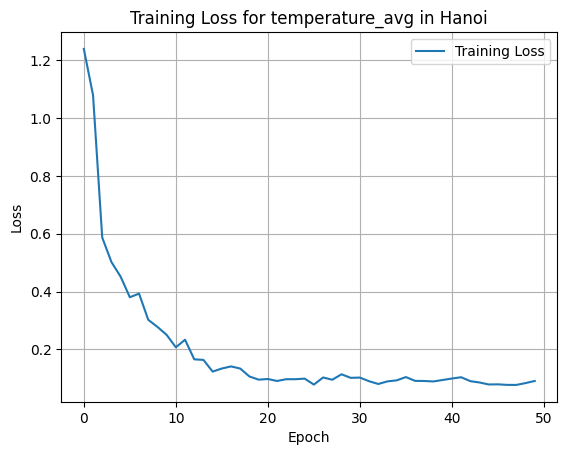

In [10]:
city_name = 'Hanoi'  
param = 'temperature_avg'

training_history = results[city_name]['histories'][param]

plt.plot(training_history.history['loss'], label='Training Loss')
plt.title(f'Training Loss for {param} in {city_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

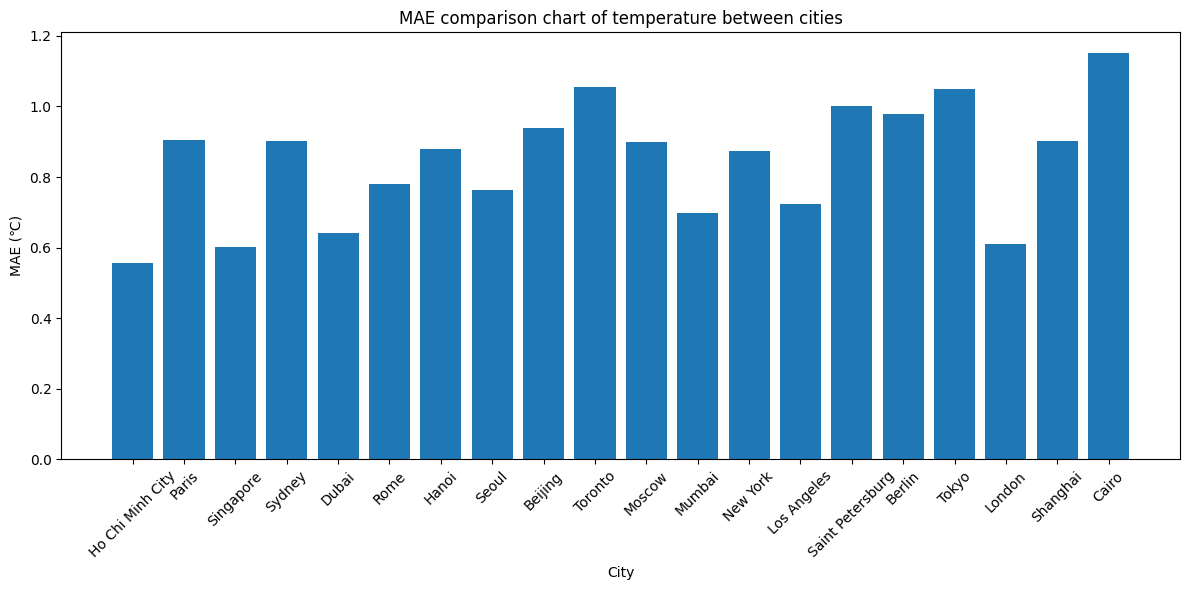

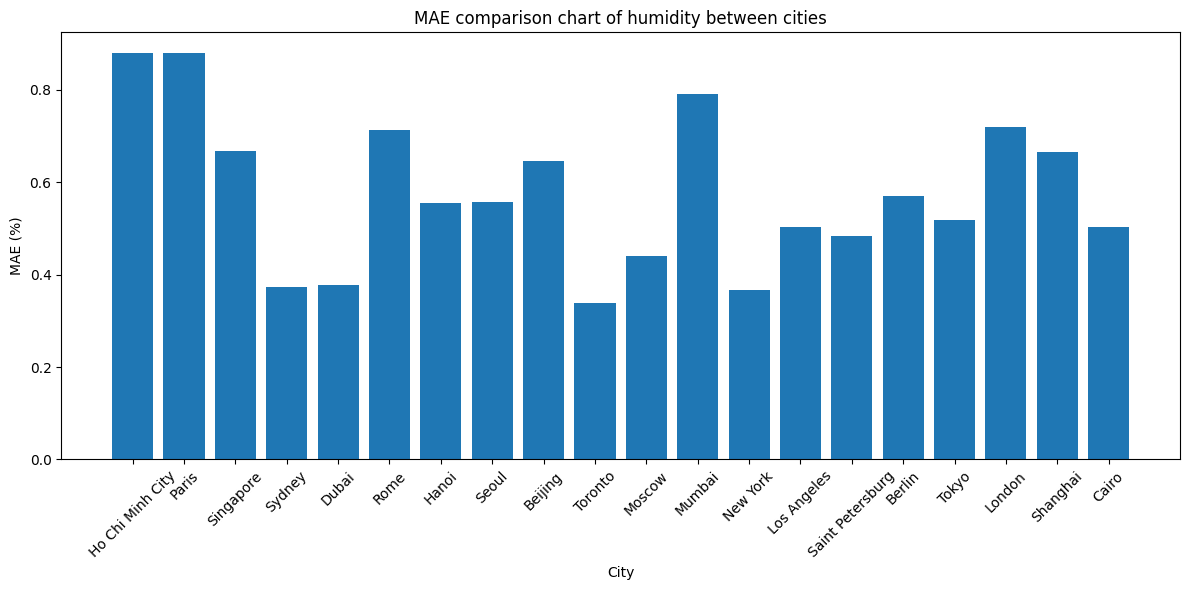

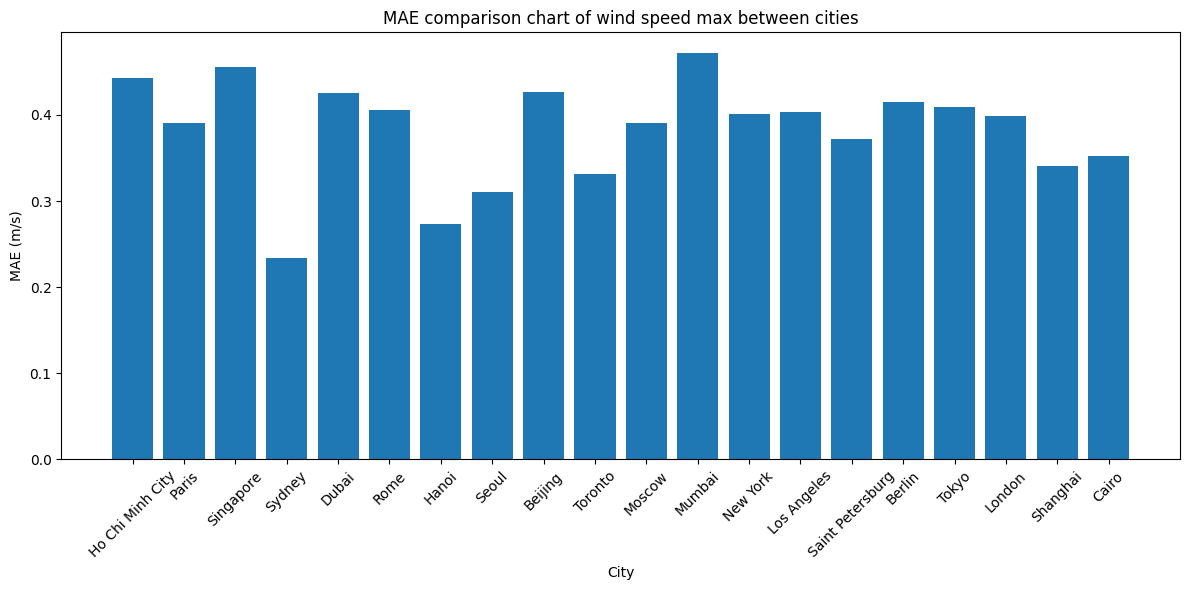

In [11]:
# MAE comparison chart of temperature between cities
cities = [city for city in results.keys() if 'temperature_avg' in results[city]['metrics']]
temps_mae = [results[city]['metrics']['temperature_avg'] for city in cities]

if cities and temps_mae:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_mae)
    plt.title('MAE comparison chart of temperature between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (℃)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

temps_hum = [results[city]['metrics']['humidity_avg'] for city in cities]

if cities and temps_hum:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_hum)
    plt.title('MAE comparison chart of humidity between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

cities = [city for city in results.keys() if 'wind_speed_max' in results[city]['metrics']]
temps_wind = [results[city]['metrics']['wind_speed_max'] for city in cities]

if cities and temps_wind:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_wind)
    plt.title('MAE comparison chart of wind speed max between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (m/s)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Ho Chi Minh City - temperature_avg


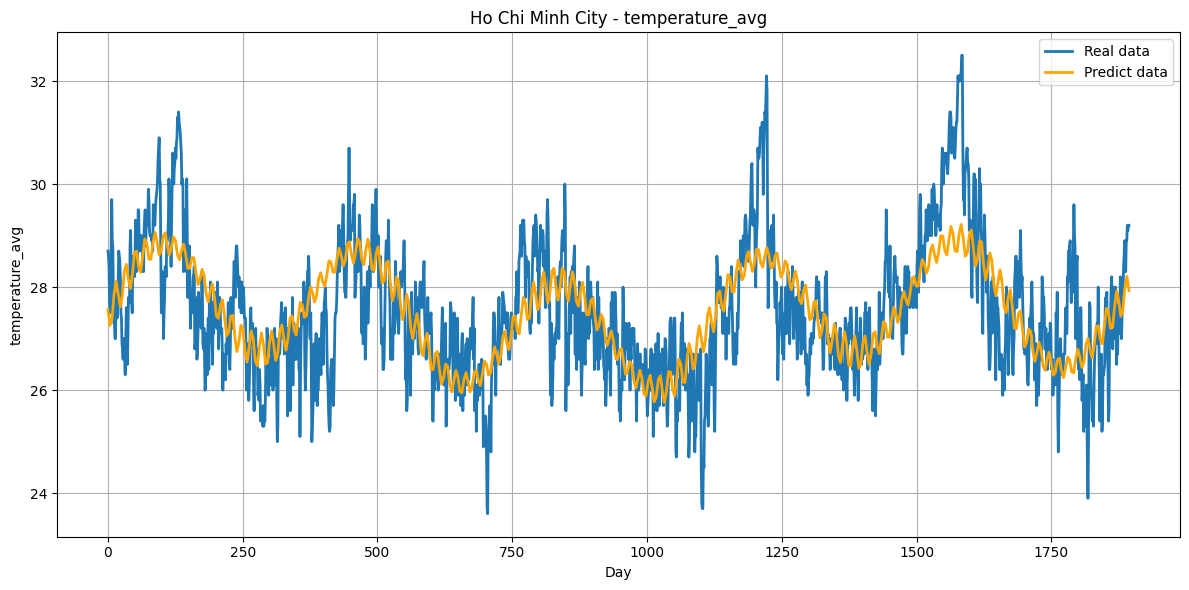


Ho Chi Minh City - humidity_avg


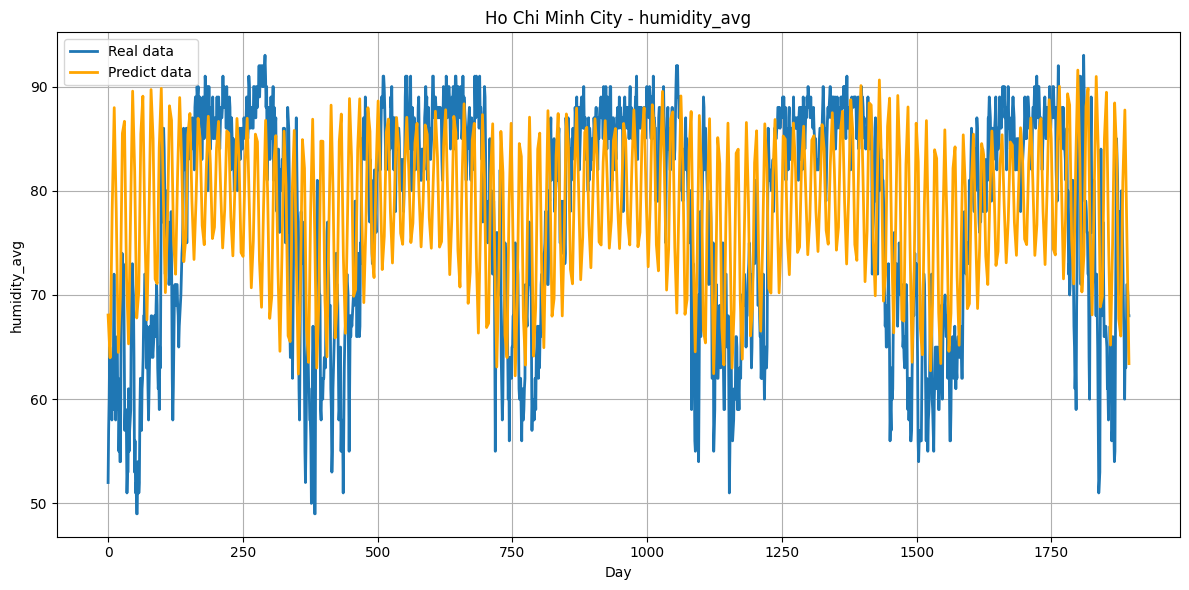


Ho Chi Minh City - wind_speed_max


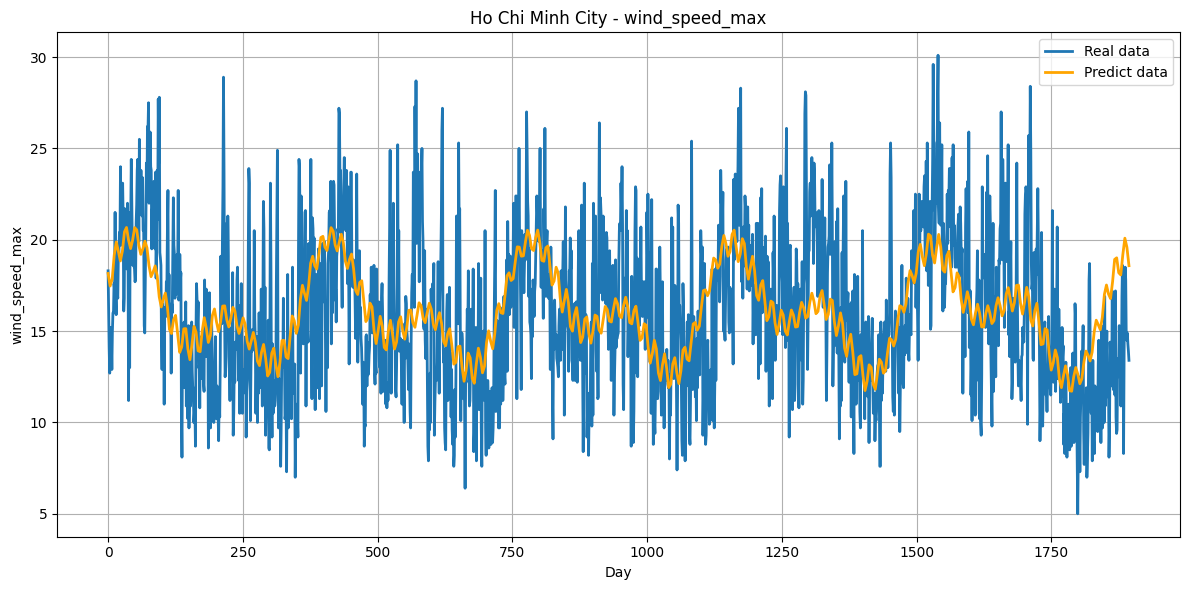


Paris - temperature_avg


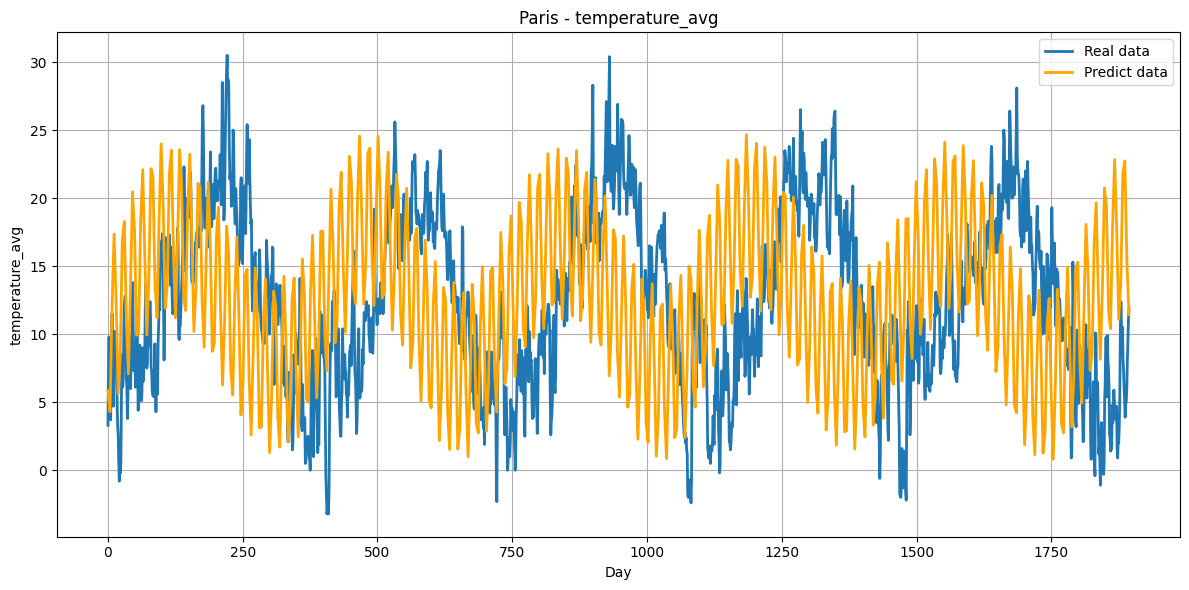


Paris - humidity_avg


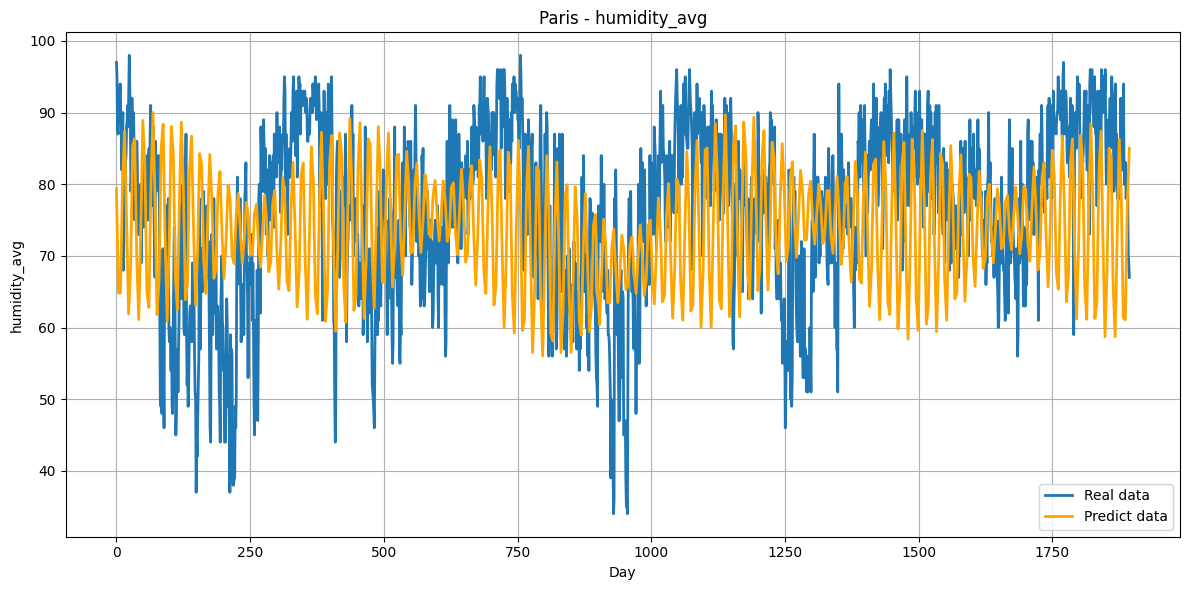


Paris - wind_speed_max


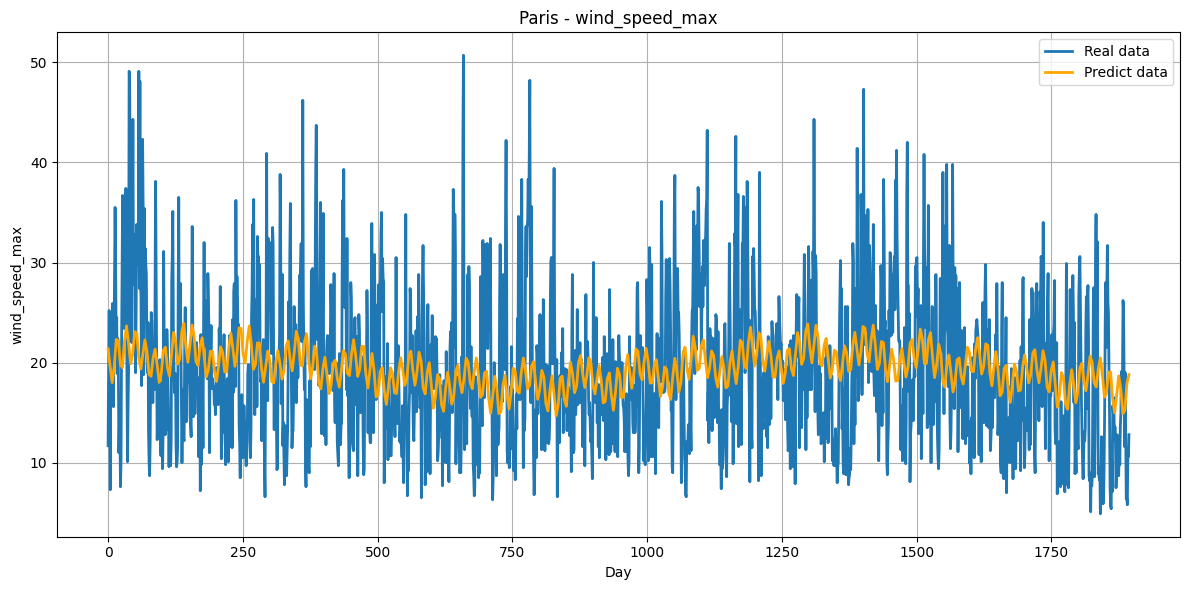


Singapore - temperature_avg


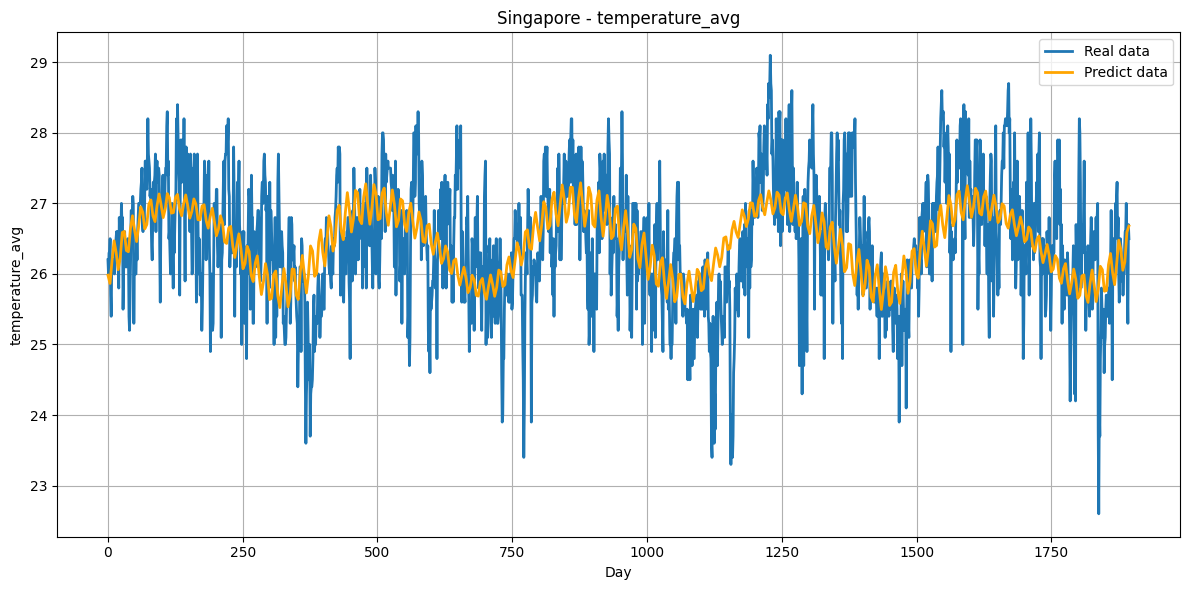


Singapore - humidity_avg


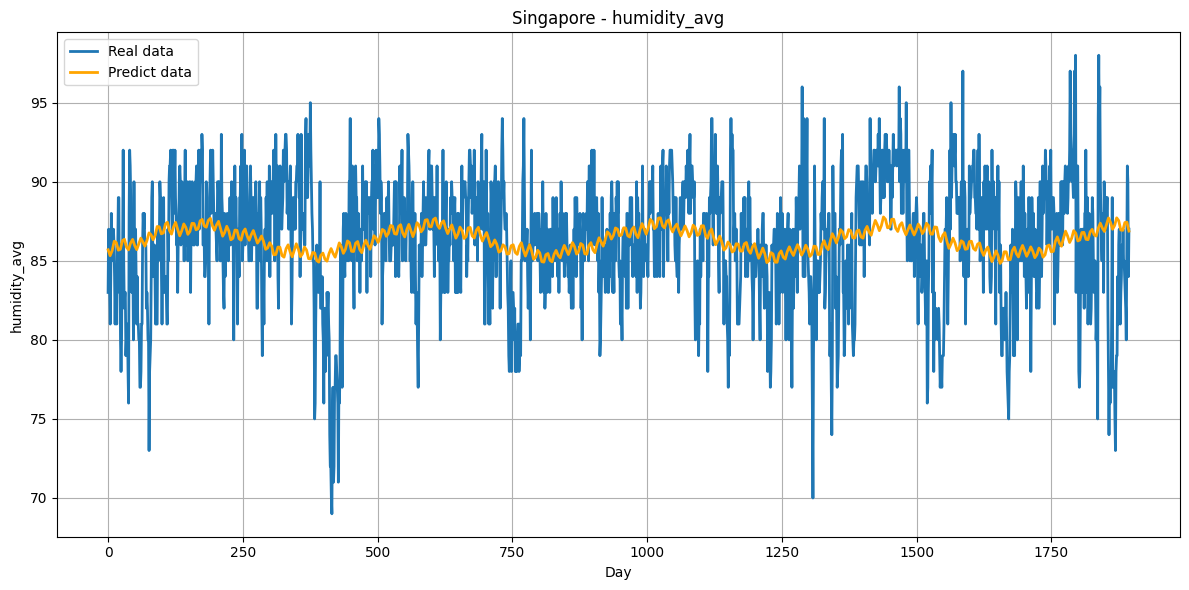


Singapore - wind_speed_max


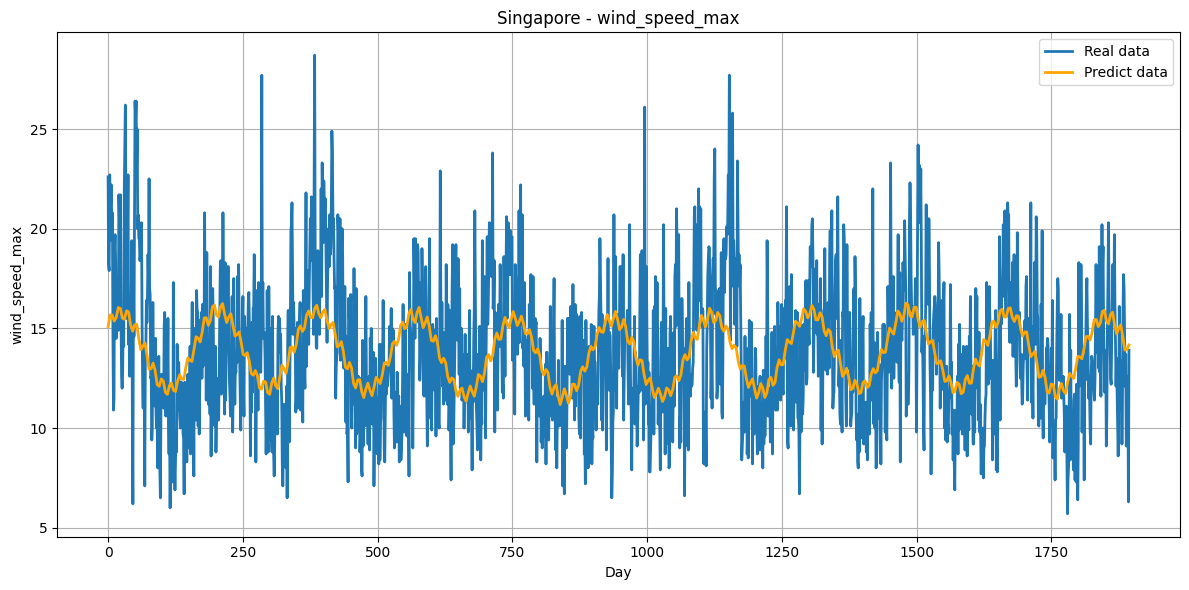

In [12]:
def plot_predictions(city_file, parameter, model, num_points=500):
    city_name = os.path.basename(city_file).replace('.csv', '')
    df = pd.read_csv(city_file)
    
    if parameter not in df.columns:
        return
    
    df['days'] = df['date'].apply(days_since_zero_date)
    
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    raw_data = data[:, 1].flatten()
    x_data = np.linspace(0, len(raw_data), len(raw_data))
    
    x_fine = np.linspace(0, len(raw_data), num_points)
    predictions = model.predict(x_fine.reshape(-1, 1), verbose=0).flatten()
    
    # Decoding predictions about the original domain
    normalize_class = Normalize(data[:, 1].reshape(-1, 1))
    denormalized_predictions = normalize_class.DeNormalizeData(predictions, axes=0)
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_data, raw_data, linewidth=2, label='Real data')
    plt.plot(x_fine, denormalized_predictions, color='orange', linewidth=2, label='Predict data')
    plt.title(f'{city_name} - {parameter}')
    plt.xlabel('Day')
    plt.ylabel(f'{parameter}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

sample_cities = cities_files[:min(3, len(cities_files))]  

for city_file in sample_cities:
    city_name = os.path.basename(city_file).replace('.csv', '')
    
    if city_name in results:
        for param in parameters:
            if param in results[city_name]['models']:
                print(f"\n{city_name} - {param}")
                plot_predictions(city_file, param, results[city_name]['models'][param])



Predict 30 next day for Ho Chi Minh City:

temperature_avg:
          date  temperature_avg
0   2025-03-09        27.614491
1   2025-03-10        27.628609
2   2025-03-11        27.642334
3   2025-03-12        27.656225
4   2025-03-13        27.670086
5   2025-03-14        27.683538
6   2025-03-15        27.697142
7   2025-03-16        27.710640
8   2025-03-17        27.723837
9   2025-03-18        27.737112
10  2025-03-19        27.750265
11  2025-03-20        27.763102
12  2025-03-21        27.776003
13  2025-03-22        27.788771
14  2025-03-23        27.801205
15  2025-03-24        27.813690
16  2025-03-25        27.826029
17  2025-03-26        27.838020
18  2025-03-27        27.850050
19  2025-03-28        27.861921
20  2025-03-29        27.873430
21  2025-03-30        27.884964
22  2025-03-31        27.896324
23  2025-04-01        27.907310
24  2025-04-02        27.918312
25  2025-04-03        27.929129
26  2025-04-04        27.939558
27  2025-04-05        27.949987
28  2025-04

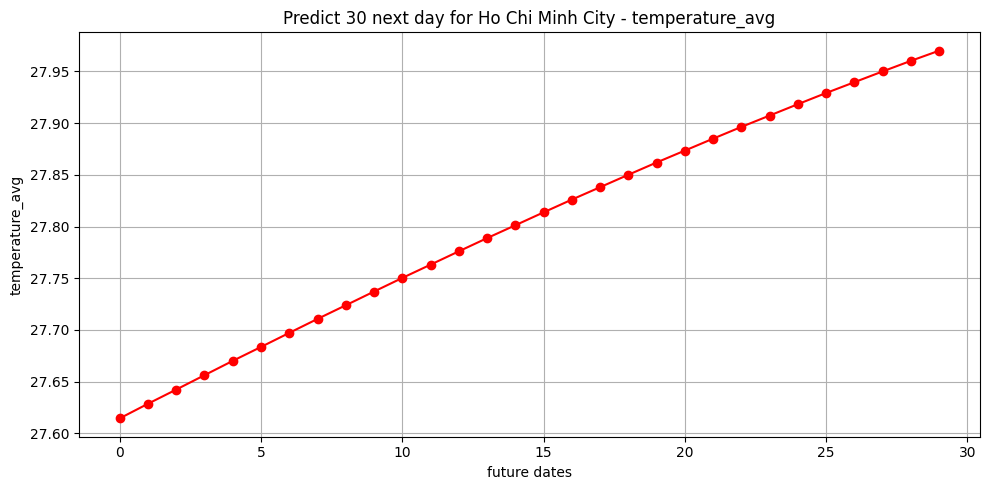


humidity_avg:
          date  humidity_avg
0   2025-03-09     68.172951
1   2025-03-10     67.898453
2   2025-03-11     67.623734
3   2025-03-12     67.355476
4   2025-03-13     67.098000
5   2025-03-14     66.843132
6   2025-03-15     66.595245
7   2025-03-16     66.354523
8   2025-03-17     66.126450
9   2025-03-18     65.900360
10  2025-03-19     65.681900
11  2025-03-20     65.471191
12  2025-03-21     65.273117
13  2025-03-22     65.078178
14  2025-03-23     64.890633
15  2025-03-24     64.716461
16  2025-03-25     64.546234
17  2025-03-26     64.384468
18  2025-03-27     64.231255
19  2025-03-28     64.090279
20  2025-03-29     63.954239
21  2025-03-30     63.826977
22  2025-03-31     63.708549
23  2025-04-01     63.602173
24  2025-04-02     63.501503
25  2025-04-03     63.409798
26  2025-04-04     63.329479
27  2025-04-05     63.255604
28  2025-04-06     63.190750
29  2025-04-07     63.134926


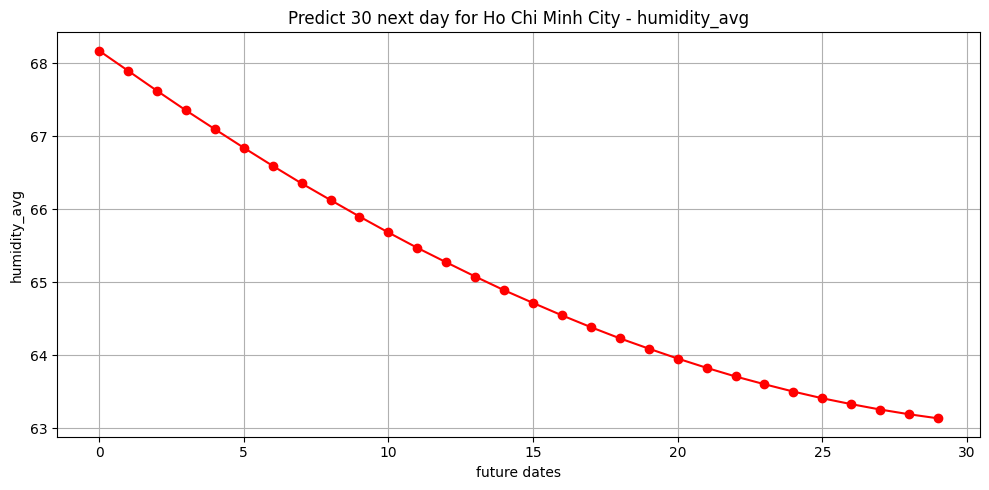


wind_speed_max:
          date  wind_speed_max
0   2025-03-09       17.775415
1   2025-03-10       17.835318
2   2025-03-11       17.892469
3   2025-03-12       17.947632
4   2025-03-13       18.000929
5   2025-03-14       18.051699
6   2025-03-15       18.100084
7   2025-03-16       18.146820
8   2025-03-17       18.190662
9   2025-03-18       18.232357
10  2025-03-19       18.272024
11  2025-03-20       18.309057
12  2025-03-21       18.344032
13  2025-03-22       18.376358
14  2025-03-23       18.406174
15  2025-03-24       18.434187
16  2025-03-25       18.459259
17  2025-03-26       18.482100
18  2025-03-27       18.502838
19  2025-03-28       18.520937
20  2025-03-29       18.536545
21  2025-03-30       18.550331
22  2025-03-31       18.561249
23  2025-04-01       18.569965
24  2025-04-02       18.576639
25  2025-04-03       18.580757
26  2025-04-04       18.582493
27  2025-04-05       18.582453
28  2025-04-06       18.579725
29  2025-04-07       18.574894


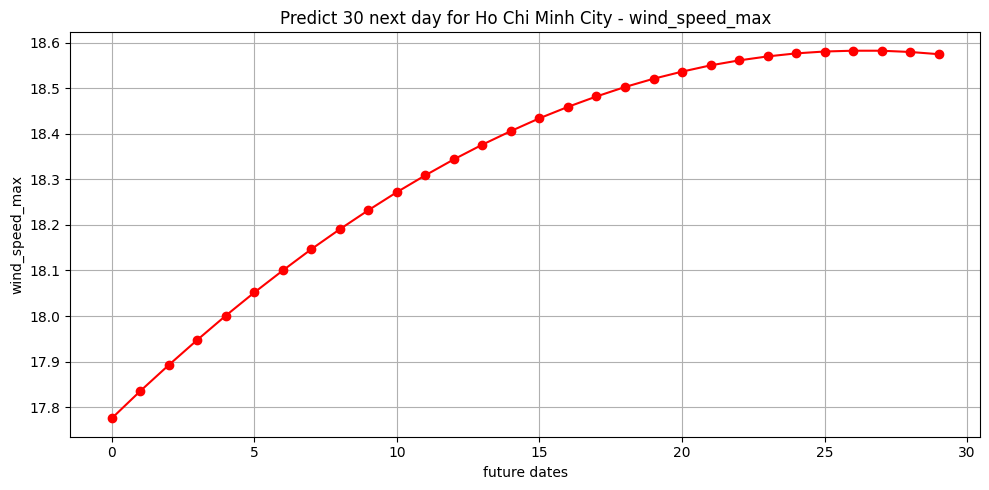


Predict 30 next day for Paris:

temperature_avg:
          date  temperature_avg
0   2025-03-09        10.708439
1   2025-03-10        10.724284
2   2025-03-11        10.742504
3   2025-03-12        10.760483
4   2025-03-13        10.779537
5   2025-03-14        10.799698
6   2025-03-15        10.820706
7   2025-03-16        10.843146
8   2025-03-17        10.867758
9   2025-03-18        10.892345
10  2025-03-19        10.918045
11  2025-03-20        10.944846
12  2025-03-21        10.972747
13  2025-03-22        11.001745
14  2025-03-23        11.032669
15  2025-03-24        11.063818
16  2025-03-25        11.096060
17  2025-03-26        11.129391
18  2025-03-27        11.163805
19  2025-03-28        11.199291
20  2025-03-29        11.236452
21  2025-03-30        11.274053
22  2025-03-31        11.312715
23  2025-04-01        11.352435
24  2025-04-02        11.394483
25  2025-04-03        11.436369
26  2025-04-04        11.479298
27  2025-04-05        11.523540
28  2025-04-06        

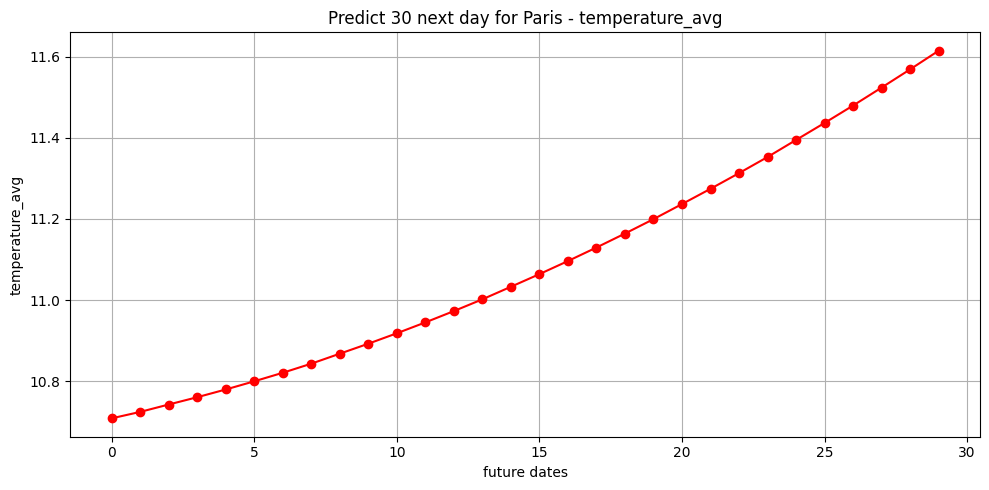


humidity_avg:
          date  humidity_avg
0   2025-03-09     86.853188
1   2025-03-10     86.826317
2   2025-03-11     86.793610
3   2025-03-12     86.757187
4   2025-03-13     86.716408
5   2025-03-14     86.672424
6   2025-03-15     86.624756
7   2025-03-16     86.572205
8   2025-03-17     86.517029
9   2025-03-18     86.460251
10  2025-03-19     86.397797
11  2025-03-20     86.329781
12  2025-03-21     86.259933
13  2025-03-22     86.186501
14  2025-03-23     86.107040
15  2025-03-24     86.026344
16  2025-03-25     85.942131
17  2025-03-26     85.856400
18  2025-03-27     85.762062
19  2025-03-28     85.667282
20  2025-03-29     85.569099
21  2025-03-30     85.463852
22  2025-03-31     85.358780
23  2025-04-01     85.250389
24  2025-04-02     85.138725
25  2025-04-03     85.021362
26  2025-04-04     84.903069
27  2025-04-05     84.781609
28  2025-04-06     84.652199
29  2025-04-07     84.524353


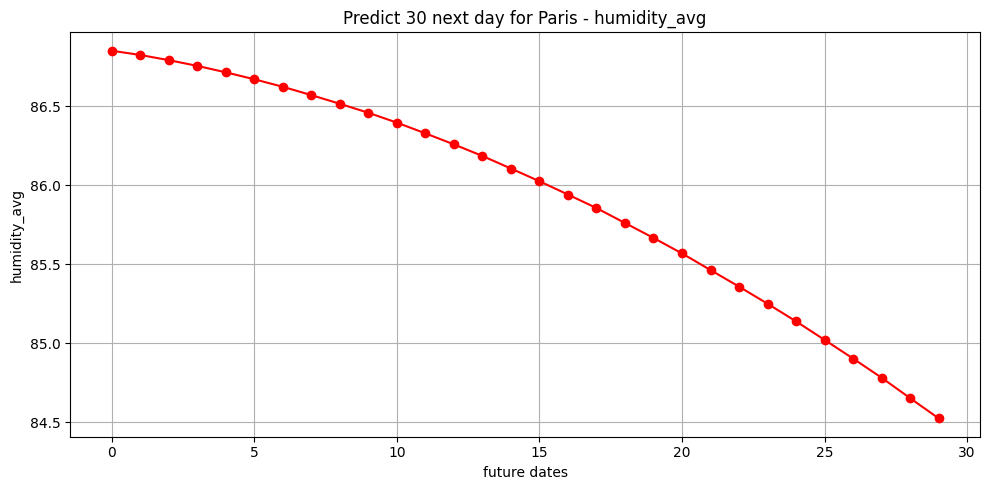


wind_speed_max:
          date  wind_speed_max
0   2025-03-09       18.865192
1   2025-03-10       18.836815
2   2025-03-11       18.810074
3   2025-03-12       18.785233
4   2025-03-13       18.762735
5   2025-03-14       18.742207
6   2025-03-15       18.723953
7   2025-03-16       18.707785
8   2025-03-17       18.693979
9   2025-03-18       18.682461
10  2025-03-19       18.673292
11  2025-03-20       18.666378
12  2025-03-21       18.661922
13  2025-03-22       18.659840
14  2025-03-23       18.659895
15  2025-03-24       18.662479
16  2025-03-25       18.667450
17  2025-03-26       18.674320
18  2025-03-27       18.683714
19  2025-03-28       18.694904
20  2025-03-29       18.708584
21  2025-03-30       18.724459
22  2025-03-31       18.741695
23  2025-04-01       18.761307
24  2025-04-02       18.782156
25  2025-04-03       18.805439
26  2025-04-04       18.830173
27  2025-04-05       18.855740
28  2025-04-06       18.883337
29  2025-04-07       18.911461


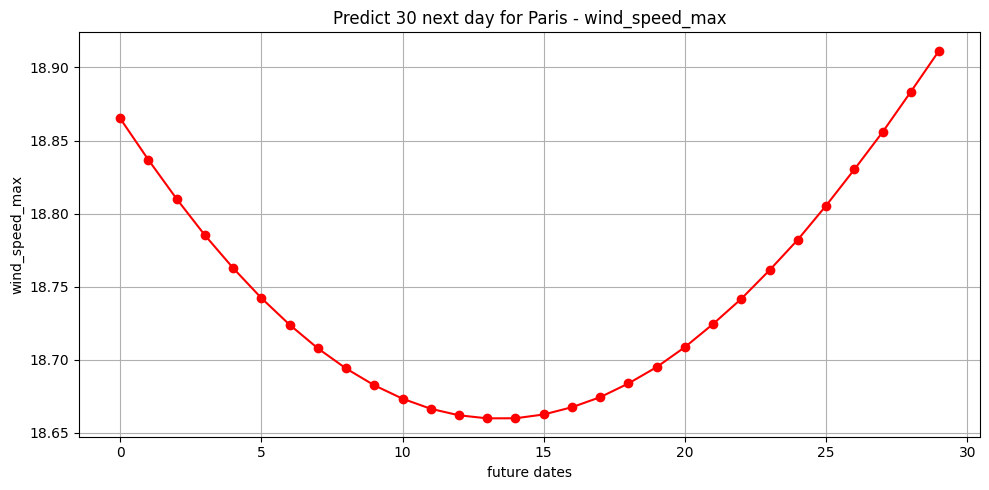


Predict 30 next day for Singapore:

temperature_avg:
          date  temperature_avg
0   2025-03-09        26.398809
1   2025-03-10        26.413652
2   2025-03-11        26.428305
3   2025-03-12        26.442606
4   2025-03-13        26.456705
5   2025-03-14        26.470587
6   2025-03-15        26.484133
7   2025-03-16        26.497372
8   2025-03-17        26.510393
9   2025-03-18        26.523046
10  2025-03-19        26.535444
11  2025-03-20        26.547459
12  2025-03-21        26.559177
13  2025-03-22        26.570597
14  2025-03-23        26.581608
15  2025-03-24        26.592339
16  2025-03-25        26.602728
17  2025-03-26        26.612692
18  2025-03-27        26.622364
19  2025-03-28        26.631605
20  2025-03-29        26.640553
21  2025-03-30        26.649185
22  2025-03-31        26.657333
23  2025-04-01        26.665186
24  2025-04-02        26.672670
25  2025-04-03        26.679710
26  2025-04-04        26.686554
27  2025-04-05        26.692867
28  2025-04-06    

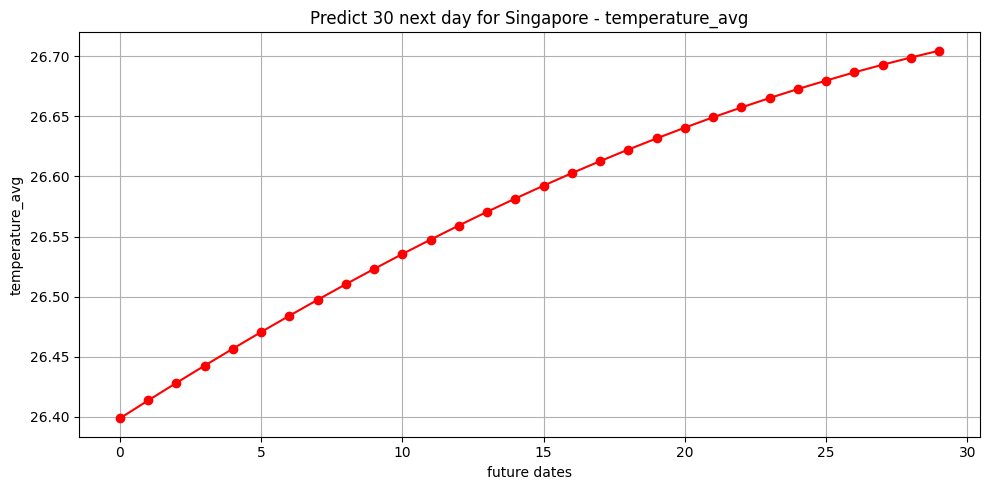


humidity_avg:
          date  humidity_avg
0   2025-03-09     87.633713
1   2025-03-10     87.613396
2   2025-03-11     87.591255
3   2025-03-12     87.567497
4   2025-03-13     87.542473
5   2025-03-14     87.515671
6   2025-03-15     87.487579
7   2025-03-16     87.458275
8   2025-03-17     87.427849
9   2025-03-18     87.396866
10  2025-03-19     87.364731
11  2025-03-20     87.331924
12  2025-03-21     87.298538
13  2025-03-22     87.264809
14  2025-03-23     87.231178
15  2025-03-24     87.197044
16  2025-03-25     87.162987
17  2025-03-26     87.129105
18  2025-03-27     87.095490
19  2025-03-28     87.062714
20  2025-03-29     87.030174
21  2025-03-30     86.998337
22  2025-03-31     86.967300
23  2025-04-01     86.937263
24  2025-04-02     86.908615
25  2025-04-03     86.880783
26  2025-04-04     86.854286
27  2025-04-05     86.829163
28  2025-04-06     86.805473
29  2025-04-07     86.783630


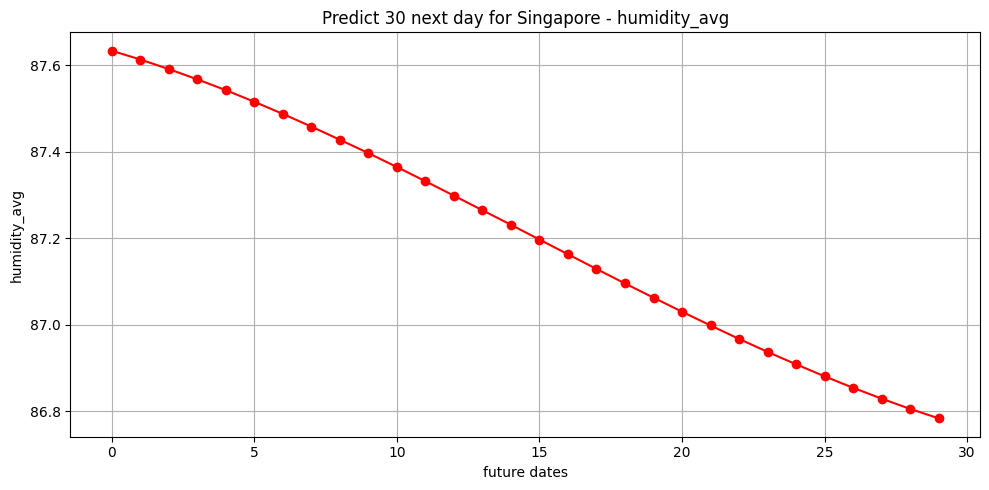


wind_speed_max:
          date  wind_speed_max
0   2025-03-09       15.200022
1   2025-03-10       15.181039
2   2025-03-11       15.159886
3   2025-03-12       15.137190
4   2025-03-13       15.112689
5   2025-03-14       15.085973
6   2025-03-15       15.057714
7   2025-03-16       15.027499
8   2025-03-17       14.995444
9   2025-03-18       14.961141
10  2025-03-19       14.925200
11  2025-03-20       14.887416
12  2025-03-21       14.847417
13  2025-03-22       14.805826
14  2025-03-23       14.762306
15  2025-03-24       14.716959
16  2025-03-25       14.669521
17  2025-03-26       14.620527
18  2025-03-27       14.569667
19  2025-03-28       14.516906
20  2025-03-29       14.462639
21  2025-03-30       14.406669
22  2025-03-31       14.349002
23  2025-04-01       14.289694
24  2025-04-02       14.228967
25  2025-04-03       14.166758
26  2025-04-04       14.103031
27  2025-04-05       14.038068
28  2025-04-06       13.971821
29  2025-04-07       13.904324


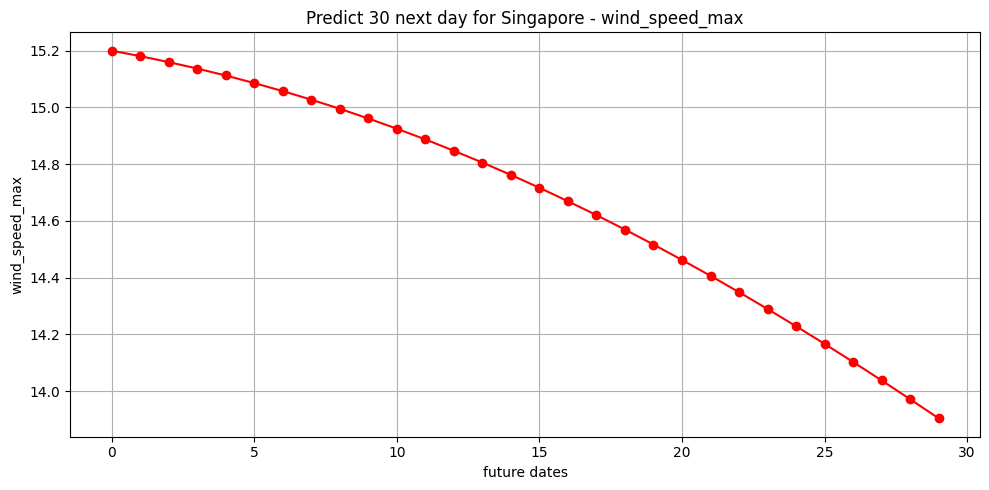

In [13]:
# predict in future
def predict_future(city_file, parameter, model, days_ahead=30):
    city_name = os.path.basename(city_file).replace('.csv', '')
    df = pd.read_csv(city_file)
    
    if parameter not in df.columns:
        return None
    
    df['days'] = df['date'].apply(days_since_zero_date)
    
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    normalize_class = Normalize(data[:, 1].reshape(-1, 1))
    normalized_data = normalize_class.normalizeData().flatten()
    
    window_size = max(1, len(normalized_data) // 70)
    if len(normalized_data) <= window_size:
        return None
    
    denoised_data = denoise_data(normalized_data, window_size)
    x_data = np.linspace(0, len(denoised_data), len(denoised_data))
    
    # Create future data points
    future_days = np.linspace(len(denoised_data), len(denoised_data) + days_ahead, days_ahead + 1)
    
    # predict
    future_predictions = model.predict(future_days.reshape(-1, 1), verbose=0).flatten()
    
    # Decoding predictions about the original domain
    denormalized_predictions = normalize_class.DeNormalizeData(future_predictions, axes=0)
    
    # Create future dates
    last_date = df['date'].iloc[-1]
    last_date_obj = datetime.strptime(last_date, "%Y-%m-%d")
    future_dates = [(last_date_obj + pd.Timedelta(days=i+1)).strftime("%Y-%m-%d") for i in range(days_ahead)]
    
    # Create DataFrame result
    future_df = pd.DataFrame({
        'date': future_dates,
        parameter: denormalized_predictions[1:], 
    })
    
    return future_df

days_to_predict = 30

for city_file in sample_cities:
    city_name = os.path.basename(city_file).replace('.csv', '')
    
    if city_name in results:
        print(f"\nPredict {days_to_predict} next day for {city_name}:")
        
        for param in parameters:
            if param in results[city_name]['models']:
                future_df = predict_future(city_file, param, results[city_name]['models'][param], days_to_predict)
                
                if future_df is not None:
                    print(f"\n{param}:")
                    print(future_df)  
                    plt.figure(figsize=(10, 5))
                    plt.plot(range(len(future_df)), future_df[param], 'r-o')
                    plt.title(f'Predict {days_to_predict} next day for {city_name} - {param}')
                    plt.xlabel('future dates')
                    plt.ylabel(param)
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

In [14]:
# save model
# import shutil

# save_models = True #False  
# if save_models:
#     os.makedirs('model', exist_ok=True)
    
#     for city_name, city_results in results.items():
#         for param in city_results['models']:
#             model = city_results['models'][param]
#             model_path = f'model/{city_name}_{param}.keras'
#             model.save(model_path)
#             print(f"Model saved for {city_name} - {param} at {model_path}")

#     shutil.make_archive('models', 'zip', 'model')
# import os
# import shutil
# import tensorflow as tf

# save_models = True  # False  
# if save_models:
#     os.makedirs('model', exist_ok=True)
    
#     for city_name, city_results in results.items():
#         for param in city_results['models']:
#             model = city_results['models'][param]
#             # Chuyển đổi model Keras sang TFLite
#             converter = tf.lite.TFLiteConverter.from_keras_model(model)
#             tflite_model = converter.convert()
#             # Lưu file TFLite
#             model_path = f'model/{city_name}_{param}.tflite'
#             with open(model_path, 'wb') as f:
#                 f.write(tflite_model)
#             print(f"Model saved for {city_name} - {param} at {model_path}")

#     shutil.make_archive('models', 'zip', 'model')


In [15]:
import tensorflow as tf
import os
import json
import shutil

def create_enhanced_model(city_file, parameter, base_model):
    """Tạo model tích hợp quá trình chuẩn hóa và giải mã"""
    
    # Đọc và xử lý dữ liệu giống như khi dự đoán
    df = pd.read_csv(city_file)
    
    if parameter not in df.columns:
        return None
    
    df['days'] = df['date'].apply(days_since_zero_date)
    
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    # Lấy thông tin chuẩn hóa
    normalize_class = Normalize(data[:, 1].reshape(-1, 1))
    normalized_data = normalize_class.normalizeData().flatten()
    
    # Lấy thông số chuẩn hóa
    mean = normalize_class._Normalize__mean[0]
    std_dev = normalize_class._Normalize__std_dev[0]
    
    # Tính toán window_size và độ dài denoised_data
    window_size = max(1, len(normalized_data) // 70)
    if len(normalized_data) <= window_size:
        return None
    
    denoised_data = denoise_data(normalized_data, window_size)
    denoised_length = len(denoised_data)
    
    # ===== Tạo lớp tùy chỉnh để denormalize trong Keras =====
    class DenormalizeLayer(tf.keras.layers.Layer):
        def __init__(self, mean, std_dev, **kwargs):
            super(DenormalizeLayer, self).__init__(**kwargs)
            self.mean = tf.constant(mean, dtype=tf.float32)
            self.std_dev = tf.constant(std_dev, dtype=tf.float32)
        
        def call(self, inputs):
            return inputs * self.std_dev + self.mean
        
        def get_config(self):
            config = super(DenormalizeLayer, self).get_config()
            config.update({
                'mean': float(self.mean.numpy()),
                'std_dev': float(self.std_dev.numpy())
            })
            return config
    
    # ===== Tạo lớp để chuyển đổi ngày nhập vào tương đối thành ngày tương lai =====
    class DayAdjustmentLayer(tf.keras.layers.Layer):
        def __init__(self, denoised_length, **kwargs):
            super(DayAdjustmentLayer, self).__init__(**kwargs)
            self.denoised_length = tf.constant(denoised_length, dtype=tf.float32)
        
        def call(self, inputs):
            # Chuyển đổi ngày tương đối (0, 1, 2...) thành ngày tương lai
            return inputs + self.denoised_length
        
        def get_config(self):
            config = super(DayAdjustmentLayer, self).get_config()
            config.update({
                'denoised_length': float(self.denoised_length.numpy())
            })
            return config
    
    # ===== Tạo model tích hợp =====
    # Input là số ngày tương lai (0, 1, 2...) tương đối
    input_layer = tf.keras.layers.Input(shape=(1,))
    
    # Chuyển đổi thành ngày tuyệt đối
    adjusted_day = DayAdjustmentLayer(denoised_length)(input_layer)
    
    # Dự đoán sử dụng model gốc
    prediction = base_model(adjusted_day)
    
    # Giải mã kết quả
    denormalized = DenormalizeLayer(mean, std_dev)(prediction)
    
    # Tạo model hoàn chỉnh
    enhanced_model = tf.keras.Model(inputs=input_layer, outputs=denormalized)
    
    # Lưu thông tin bổ sung để hiểu rõ về model
    model_info = {
        'mean': float(mean),
        'std_dev': float(std_dev),
        'denoised_length': int(denoised_length),
        'city': os.path.basename(city_file).replace('.csv', ''),
        'parameter': parameter
    }
    
    return enhanced_model, model_info

# ==== Sửa đổi phần lưu model ====
save_models = True
if save_models:
    os.makedirs('model', exist_ok=True)
    os.makedirs('model_info', exist_ok=True)
    
    for city_file in cities_files:
        city_name = os.path.basename(city_file).replace('.csv', '')
        
        if city_name in results:
            for param in parameters:
                if param in results[city_name]['models']:
                    base_model = results[city_name]['models'][param]
                    
                    # Tạo model tích hợp
                    enhanced_model, model_info = create_enhanced_model(city_file, param, base_model)
                    
                    if enhanced_model is not None:
                        # Lưu thông tin model
                        info_path = f'model_info/{city_name}_{param}_info.json'
                        with open(info_path, 'w') as f:
                            json.dump(model_info, f)
                        
                        # Chuyển đổi model sang TFLite
                        converter = tf.lite.TFLiteConverter.from_keras_model(enhanced_model)
                        tflite_model = converter.convert()
                        
                        # Lưu file TFLite
                        model_path = f'model/{city_name}_{param}.tflite'
                        with open(model_path, 'wb') as f:
                            f.write(tflite_model)
                        
                        print(f"Enhanced model saved for {city_name} - {param} at {model_path}")
    
    # Đóng gói thành file zip
    shutil.make_archive('modelzz', 'zip', 'model')
    shutil.make_archive('model_info', 'zip', 'model_info')

Saved artifact at '/tmp/tmpgth3_28n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_3000')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137634292468368: TensorSpec(shape=(), dtype=tf.float32, name=None)
  137639108287072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639108290768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137634492292384: TensorSpec(shape=(), dtype=tf.float32, name=None)
  137634292477344: TensorSpec(shape=(), dtype=tf.float32, name=None)
Enhanced model saved for Ho Chi Minh City - temperature_avg at model/Ho Chi Minh City_temperature_avg.tflite
Saved artifact at '/tmp/tmp1o7tczs6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_3004')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=No

In [21]:
import tensorflow as tf
import os
import json
import shutil

save_models = True
if save_models:
    for folder in ['model', 'model_info', 'model_keras', 'model_keras_base', 'optimized_models']:
        if os.path.exists(folder):
            shutil.rmtree(folder)
            print(f"Delete: {folder}")
    # Tạo các thư mục cần thiết
    os.makedirs('model', exist_ok=True)
    os.makedirs('model_info', exist_ok=True)
    os.makedirs('model_keras', exist_ok=True)  # Thư mục mới cho các model Keras
    os.makedirs('model_keras_base', exist_ok=True)  # Thư mục mới cho các base model Keras
    
    for city_file in cities_files:
        city_name = os.path.basename(city_file).replace('.csv', '')
        
        if city_name in results:
            for param in parameters:
                if param in results[city_name]['models']:
                    base_model = results[city_name]['models'][param]
                    
                    # Lưu base model dạng Keras
                    base_model_path = f'model_keras_base/{city_name}_{param}.keras'
                    base_model.save(base_model_path)
                    print(f"Base model saved for {city_name} - {param} at {base_model_path}")
                    
                    # Tạo model tích hợp
                    enhanced_model, model_info = create_enhanced_model(city_file, param, base_model)
                    
                    if enhanced_model is not None:
                        # Lưu thông tin model
                        info_path = f'model_info/{city_name}_{param}_info.json'
                        with open(info_path, 'w') as f:
                            json.dump(model_info, f)
                        
                        # Lưu enhanced model dạng Keras
                        keras_model_path = f'model_keras/{city_name}_{param}.keras'
                        enhanced_model.save(keras_model_path)
                        print(f"Enhanced Keras model saved for {city_name} - {param} at {keras_model_path}")
                        
                        # Chuyển đổi model sang TFLite (giữ lại phần này từ code gốc)
                        converter = tf.lite.TFLiteConverter.from_keras_model(enhanced_model)
                        tflite_model = converter.convert()
                        
                        # Lưu file TFLite
                        model_path = f'model/{city_name}_{param}.tflite'
                        with open(model_path, 'wb') as f:
                            f.write(tflite_model)
                        
                        print(f"Enhanced TFLite model saved for {city_name} - {param} at {model_path}")
    
    # Đóng gói thành file zip
    shutil.make_archive('model', 'zip', 'model')  # TFLite models
    shutil.make_archive('model_info', 'zip', 'model_info')  # Model info
    shutil.make_archive('model_keras', 'zip', 'model_keras')  # Enhanced Keras models
    shutil.make_archive('model_keras_base', 'zip', 'model_keras_base')  # Base Keras models

Delete: model
Delete: model_info
Delete: model_keras
Delete: model_keras_base
Delete: optimized_models
Base model saved for Ho Chi Minh City - temperature_avg at model_keras_base/Ho Chi Minh City_temperature_avg.keras
Enhanced Keras model saved for Ho Chi Minh City - temperature_avg at model_keras/Ho Chi Minh City_temperature_avg.keras
Saved artifact at '/tmp/tmp9eyp_bs8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_3960')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137635834920128: TensorSpec(shape=(), dtype=tf.float32, name=None)
  137639108287072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137639108290768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137635838870800: TensorSpec(shape=(), dtype=tf.float32, name=None)
  137635834914848: TensorSpec(shape=(), dtype=tf.float32, name=None)
Enhanced TFLite model saved for Ho C